Accuracy: 87.74 %


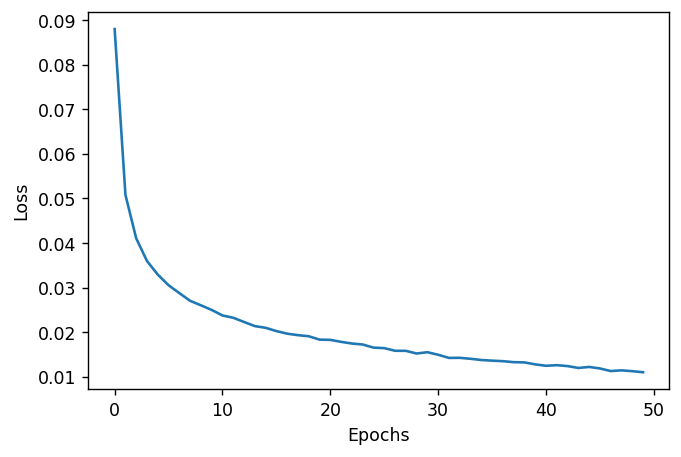

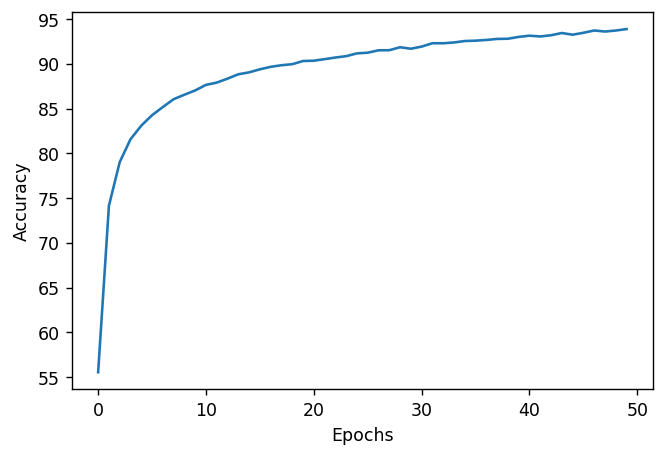

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def load_data(path):
    def one_hot(y):
        table = np.zeros((y.shape[0], 10))
        for i in range(y.shape[0]):
            table[i][int(y[i][0])] = 1 
        return table

    def normalize(x): 
        x = x / 255
        return x 

    data = np.loadtxt('{}'.format(path), delimiter = ',')
    return normalize(data[:,1:]),one_hot(data[:,:1])

X_train, y_train = load_data('/content/sample_data/mnist_train.csv')
X_test, y_test = load_data('/content/sample_data/mnist_test.csv')

class NeuralNetwork:
    def __init__(self, X, y, batch = 64, lr = 1e-3,  epochs = 50):
        self.input = X 
        self.target = y
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        
        self.x = self.input[:self.batch] # batch input 
        self.y = self.target[:self.batch] # batch target value
        self.loss = []
        self.acc = []
        
        self.init_weights()
      
    def init_weights(self):
        self.W1 = np.random.randn(self.input.shape[1],256)
        self.W2 = np.random.randn(self.W1.shape[1],128)
        self.W3 = np.random.randn(self.W2.shape[1],self.y.shape[1])

        self.b1 = np.random.randn(self.W1.shape[1],)
        self.b2 = np.random.randn(self.W2.shape[1],)
        self.b3 = np.random.randn(self.W3.shape[1],)

    def ReLU(self, x):
        return np.maximum(0,x)

    def dReLU(self,x):
        return 1 * (x > 0) 
    
    def softmax(self, z):
        z = z - np.max(z, axis = 1).reshape(z.shape[0],1)
        return np.exp(z) / np.sum(np.exp(z), axis = 1).reshape(z.shape[0],1)
    
    def shuffle(self):
        idx = [i for i in range(self.input.shape[0])]
        np.random.shuffle(idx)
        self.input = self.input[idx]
        self.target = self.target[idx]
        
    def feedforward(self):
        assert self.x.shape[1] == self.W1.shape[0]
        self.z1 = self.x.dot(self.W1) + self.b1
        self.a1 = self.ReLU(self.z1)

        assert self.a1.shape[1] == self.W2.shape[0]
        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.ReLU(self.z2)

        assert self.a2.shape[1] == self.W3.shape[0]
        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.softmax(self.z3)
        self.error = self.a3 - self.y

        
    def backprop(self):
        dcost = (1/self.batch)*self.error
        
        DW3 = np.dot(dcost.T,self.a2).T
        DW2 = np.dot((np.dot((dcost),self.W3.T) * self.dReLU(self.z2)).T,self.a1).T
        DW1 = np.dot((np.dot(np.dot((dcost),self.W3.T)*self.dReLU(self.z2),self.W2.T)*self.dReLU(self.z1)).T,self.x).T

        db3 = np.sum(dcost,axis = 0)
        db2 = np.sum(np.dot((dcost),self.W3.T) * self.dReLU(self.z2),axis = 0)
        db1 = np.sum((np.dot(np.dot((dcost),self.W3.T)*self.dReLU(self.z2),self.W2.T)*self.dReLU(self.z1)),axis = 0)
        
        assert DW3.shape == self.W3.shape
        assert DW2.shape == self.W2.shape
        assert DW1.shape == self.W1.shape
        
        assert db3.shape == self.b3.shape
        assert db2.shape == self.b2.shape
        assert db1.shape == self.b1.shape 
        
        self.W3 = self.W3 - self.lr * DW3
        self.W2 = self.W2 - self.lr * DW2
        self.W1 = self.W1 - self.lr * DW1
        
        self.b3 = self.b3 - self.lr * db3
        self.b2 = self.b2 - self.lr * db2
        self.b1 = self.b1 - self.lr * db1

    def train(self):
        for epoch in range(self.epochs):
            l = 0
            acc = 0
            self.shuffle()
            
            for batch in range(self.input.shape[0]//self.batch-1):
                start = batch*self.batch
                end = (batch+1)*self.batch
                self.x = self.input[start:end]
                self.y = self.target[start:end]
                self.feedforward()
                self.backprop()
                l+=np.mean(self.error**2)
                acc+= np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.batch
                
            self.loss.append(l/(self.input.shape[0]//self.batch))
            self.acc.append(acc*100/(self.input.shape[0]//self.batch))
            
    def plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.loss)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
    
    def acc_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.acc)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        
    def test(self,xtest,ytest):
        self.x = xtest
        self.y = ytest
        self.feedforward()
        acc = np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.x.shape[0]
        print("Accuracy:", 100 * acc, "%")
    
        
        
NN = NeuralNetwork(X_train, y_train) 
NN.train()
NN.plot()
NN.test(X_test,y_test)

NN.acc_plot()